## Imports & Setup

In [1]:
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, f1_score, hamming_loss, jaccard_score
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print("All imports successful ✓")

Using device: cpu
All imports successful ✓


## Load Dataset

In [11]:
df = pd.read_csv('movies.csv')

# Keep only the allowed columns (with correct CSV names)
df = df[['genres', 'keywords', 'tagline', 'overview', 'vote_average']].copy()

# Rename to match assignment terminology
df.rename(columns={'genres': 'genre', 'vote_average': 'voting_average'}, inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"\nNull counts:")
print(df.isnull().sum())
print(f"\nSample row:")
df.head()

Dataset shape: (4803, 5)

Null counts:
genre              28
keywords          412
tagline           844
overview            4
voting_average      0
dtype: int64

Sample row:


,genre,keywords,tagline,overview,voting_average
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",7.2
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",6.9
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,6.3
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,The Legend Ends,Following the death of District Attorney Harve...,7.6
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"Lost in our world, found in another.","John Carter is a war-weary, former military ca...",6.1


## Data Cleaning & Missing Value Handling

In [14]:
df.dropna(subset=['genre', 'overview'], inplace=True)

for col in ['keywords', 'tagline']:
    df[col] = df[col].fillna('')

df.reset_index(drop=True, inplace=True)
print(f"Cleaned dataset shape: {df.shape}")
print(f"voting_average range: {df['voting_average'].min():.1f} – {df['voting_average'].max():.1f}")
print(f"voting_average mean: {df['voting_average'].mean():.3f}")

Cleaned dataset shape: (4771, 6)
voting_average range: 0.0 – 10.0
voting_average mean: 6.115


## Parse Multi-Label Genres

In [16]:
df['genre_list'] = df['genre'].apply(lambda x: x.strip().split() if isinstance(x, str) else [])

all_genres = [g for sublist in df['genre_list'] for g in sublist]
genre_counts = Counter(all_genres)
print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 15 genres by frequency:")
for genre, count in genre_counts.most_common(15):
    print(f"  {genre:<25} {count}")

Total unique genres: 22

Top 15 genres by frequency:
  Drama                     2296
  Comedy                    1721
  Thriller                  1259
  Action                    1152
  Romance                   890
  Adventure                 790
  Crime                     696
  Science                   529
  Fiction                   529
  Horror                    519
  Family                    510
  Fantasy                   418
  Mystery                   347
  Animation                 234
  History                   197


## Text Preprocessing Function

In [17]:
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text: str) -> list:
    if not isinstance(text, str) or text.strip() == '':
        return []
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in STOPWORDS and len(tok) > 2
    ]
    return tokens

def tokens_to_string(tokens: list) -> str:
    return ' '.join(tokens)


# Apply preprocessing to all three text columns


In [18]:
print("Preprocessing text columns")
for col in ['overview', 'tagline', 'keywords']:
    df[f'{col}_tokens'] = df[col].apply(preprocess_text)
    df[f'{col}_clean'] = df[f'{col}_tokens'].apply(tokens_to_string)
    print(f"  ✓ {col} done")
print(df.shape)
# Preview
print("\nExample (overview):")
print(f"  ORIGINAL : {df['overview'].iloc[0][:80]}...")
print(f"  PROCESSED: {df['overview_clean'].iloc[0][:80]}...")

df.head()

Preprocessing text columns
  ✓ overview done
  ✓ tagline done
  ✓ keywords done
(4771, 12)

Example (overview):
  ORIGINAL : In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a ...
  PROCESSED: century paraplegic marine dispatched moon pandora unique mission becomes torn fo...


,genre,keywords,tagline,overview,voting_average,genre_list,overview_tokens,overview_clean,tagline_tokens,tagline_clean,keywords_tokens,keywords_clean
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",7.2,"[Action, Adventure, Fantasy, Science, Fiction]","[century, paraplegic, marine, dispatched, moon...",century paraplegic marine dispatched moon pand...,"[enter, world, pandora]",enter world pandora,"[culture, clash, future, space, war, space, co...",culture clash future space war space colony so...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",6.9,"[Adventure, Fantasy, Action]","[captain, barbossa, long, believed, dead, come...",captain barbossa long believed dead come back ...,"[end, world, adventure, begin]",end world adventure begin,"[ocean, drug, abuse, exotic, island, east, ind...",ocean drug abuse exotic island east india trad...
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,6.3,"[Action, Adventure, Crime]","[cryptic, message, bond, past, sends, trail, u...",cryptic message bond past sends trail uncover ...,"[plan, one, escape]",plan one escape,"[spy, based, novel, secret, agent, sequel]",spy based novel secret agent sequel
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,The Legend Ends,Following the death of District Attorney Harve...,7.6,"[Action, Crime, Drama, Thriller]","[following, death, district, attorney, harvey,...",following death district attorney harvey dent ...,"[legend, end]",legend end,"[comic, crime, fighter, terrorist, secret, ide...",comic crime fighter terrorist secret identity ...
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"Lost in our world, found in another.","John Carter is a war-weary, former military ca...",6.1,"[Action, Adventure, Science, Fiction]","[john, carter, warweary, former, military, cap...",john carter warweary former military captain w...,"[lost, world, found, another]",lost world found another,"[based, novel, mar, medallion, space, travel, ...",based novel mar medallion space travel princess


# Data Split
## Train / Validation / Test Split (70 / 15 / 15)

In [19]:
# First split: 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    df.index, test_size=0.30, random_state=SEED
)
# Second split: temp → 50% val (15%), 50% test (15%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, random_state=SEED
)

train_df = df.loc[train_idx].reset_index(drop=True)
val_df   = df.loc[val_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

print(f"Train size : {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size   : {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size  : {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size : 3339 (70.0%)
Val size   : 716 (15.0%)
Test size  : 716 (15.0%)


## Load GloVe Vectors

In [21]:
# Download GloVe pre-trained vectors (if not already downloaded)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# You should see files like glove.6B.50d.txt, glove.6B.100d.txt, etc.
# Let's use the 100-dimensional vectors as an example.
GLOVE_FILE = 'glove.6B.100d.txt'

--2026-02-20 12:08:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-20 12:08:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-20 12:08:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [22]:
GLOVE_PATH = "/content/glove.6B.100d.txt"
GLOVE_DIM = 100

print(f"Loading GloVe {GLOVE_DIM}D vectors from: {GLOVE_PATH}")
glove = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        try:
            vector = np.array(parts[1:], dtype=np.float32)
        except ValueError:
            continue  # skip malformed lines
        if len(vector) == GLOVE_DIM:
            glove[word] = vector

print(f"✓ Loaded {len(glove):,} GloVe word vectors (dim={GLOVE_DIM})")

Loading GloVe 100D vectors from: /content/glove.6B.100d.txt
✓ Loaded 400,000 GloVe word vectors (dim=100)


## GloVe Coverage Report

In [23]:
def compute_coverage(token_series, glove_vocab):

    all_tokens = set(tok for tokens in token_series for tok in tokens)
    covered = {t for t in all_tokens if t in glove_vocab}
    pct = len(covered) / len(all_tokens) * 100 if all_tokens else 0
    return len(all_tokens), len(covered), pct

print("GloVe Embedding Coverage Report")
for col in ['overview', 'tagline', 'keywords']:
    total, covered, pct = compute_coverage(df[f'{col}_tokens'], glove)
    print(f"  {col:<12}: {covered:,} / {total:,} unique tokens  →  {pct:.1f}% covered")

GloVe Embedding Coverage Report
  overview    : 17,772 / 20,258 unique tokens  →  87.7% covered
  tagline     : 3,403 / 3,592 unique tokens  →  94.7% covered
  keywords    : 4,022 / 4,173 unique tokens  →  96.4% covered


## TF-IDF Weighted GloVe Document Embeddings

In [24]:
def build_tfidf_glove_embeddings(train_texts, all_texts, glove_vocab, dim=100):

    vectorizer = TfidfVectorizer(min_df=1)
    vectorizer.fit(train_texts)
    vocab = vectorizer.vocabulary_
    idf   = vectorizer.idf_

    tfidf_matrix = vectorizer.transform(all_texts)

    embeddings = np.zeros((len(all_texts), dim), dtype=np.float32)

    for i in range(len(all_texts)):
        row = tfidf_matrix[i]                    # sparse row
        word_indices = row.indices               # columns with non-zero tfidf
        tfidf_weights = row.data                 # corresponding tfidf values

        weighted_sum = np.zeros(dim, dtype=np.float32)
        weight_total = 0.0

        index_to_word = {v: k for k, v in vocab.items()}

        for idx, weight in zip(word_indices, tfidf_weights):
            word = index_to_word.get(idx)
            if word and word in glove_vocab:
                weighted_sum += weight * glove_vocab[word]
                weight_total += weight

        if weight_total > 0:
            embeddings[i] = weighted_sum / weight_total

    return vectorizer, embeddings



embeddings = {}
tfidf_vectorizers = {}

for col in ['overview', 'tagline', 'keywords']:
    print(f"Building TF-IDF GloVe embeddings for: {col}")

    train_texts = train_df[f'{col}_clean'].tolist()
    val_texts   = val_df[f'{col}_clean'].tolist()
    test_texts  = test_df[f'{col}_clean'].tolist()
    all_texts   = train_texts + val_texts + test_texts

    vectorizer, all_emb = build_tfidf_glove_embeddings(
        train_texts, all_texts, glove, GLOVE_DIM
    )
    tfidf_vectorizers[col] = vectorizer

    n_train = len(train_texts)
    n_val   = len(val_texts)
    embeddings[col] = {
        'train': all_emb[:n_train],
        'val'  : all_emb[n_train:n_train+n_val],
        'test' : all_emb[n_train+n_val:]
    }
    print(f"Train: {embeddings[col]['train'].shape}, Val: {embeddings[col]['val'].shape}, Test: {embeddings[col]['test'].shape}")

Building TF-IDF GloVe embeddings for: overview
Train: (3339, 100), Val: (716, 100), Test: (716, 100)
Building TF-IDF GloVe embeddings for: tagline
Train: (3339, 100), Val: (716, 100), Test: (716, 100)
Building TF-IDF GloVe embeddings for: keywords
Train: (3339, 100), Val: (716, 100), Test: (716, 100)


## Neural Network Architecture

We define two networks that share the same structure:

| Layer | Regression | Classification |
|-------|-----------|----------------|
| Input | 100 (GloVe dim) | 100 |
| Hidden 1 | 128, ReLU, Dropout 0.3 | 128, ReLU, Dropout 0.3 |
| Hidden 2 | 128, ReLU | 128, ReLU |
| Output | 1 (single float) | N_genres |

In [25]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)


class ClassificationNet(nn.Module):

    def __init__(self, input_dim=100, num_labels=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_labels)
        )
    def forward(self, x):
        return self.net(x)


print("Model architectures defined")
# Quick sanity check
dummy = torch.zeros(4, GLOVE_DIM)
reg_net = RegressionNet(GLOVE_DIM)
cls_net = ClassificationNet(GLOVE_DIM, num_labels=5)
print(f"  Regression output shape  : {reg_net(dummy).shape}  (expected: [4])")
print(f"  Classification output shape: {cls_net(dummy).shape}  (expected: [4, 5])")

Model architectures defined
  Regression output shape  : torch.Size([4])  (expected: [4])
  Classification output shape: torch.Size([4, 5])  (expected: [4, 5])


## Training Helper Functions

In [26]:
def make_dataloader(X, y, batch_size=64, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    return DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=shuffle)


def train_model(model, train_loader, val_loader, loss_fn,
                epochs=50, lr=1e-3, task='regression'):

    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        total_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(Xb)

        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                preds = model(Xb)
                val_loss += loss_fn(preds, yb).item() * len(Xb)

        history['train_loss'].append(total_loss / len(train_loader.dataset))
        history['val_loss'].append(val_loss / len(val_loader.dataset))

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f} | "
                  f"Val Loss: {history['val_loss'][-1]:.4f}")

    return history


def plot_loss_curve(history, title='Training Curve'):
    plt.figure(figsize=(8, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.show()

print("Training helpers defined ✓")

Training helpers defined ✓


## Prepare Regression Targets

In [27]:
y_reg_train = train_df['voting_average'].values.astype(np.float32)
y_reg_val   = val_df['voting_average'].values.astype(np.float32)
y_reg_test  = test_df['voting_average'].values.astype(np.float32)

GLOBAL_MEAN = y_reg_train.mean()
print(f"Global mean rating (baseline prediction): {GLOBAL_MEAN:.4f}")

# Baseline model: always predict the global mean
baseline_preds = np.full_like(y_reg_test, GLOBAL_MEAN)
baseline_mse  = mean_squared_error(y_reg_test, baseline_preds)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline MSE  (predict mean always): {baseline_mse:.4f}")
print(f"Baseline RMSE (predict mean always): {baseline_rmse:.4f}")

Global mean rating (baseline prediction): 6.1180
Baseline MSE  (predict mean always): 1.3666
Baseline RMSE (predict mean always): 1.1690


## Task 3A: Regression with `overview` Embeddings

=== Task 3: Results on 'overview' ===
=== Regression: input = 'overview' ===
  Epoch  10/100 | Train Loss: 1.4599 | Val Loss: 1.4865
  Epoch  20/100 | Train Loss: 1.2977 | Val Loss: 1.3844
  Epoch  30/100 | Train Loss: 1.1735 | Val Loss: 1.4154
  Epoch  40/100 | Train Loss: 1.1519 | Val Loss: 1.3790
  Epoch  50/100 | Train Loss: 1.0862 | Val Loss: 1.4269
  Epoch  60/100 | Train Loss: 1.0373 | Val Loss: 1.3847
  Epoch  70/100 | Train Loss: 0.9599 | Val Loss: 1.4152
  Epoch  80/100 | Train Loss: 0.8956 | Val Loss: 1.4562
  Epoch  90/100 | Train Loss: 0.8518 | Val Loss: 1.4327
  Epoch 100/100 | Train Loss: 0.7852 | Val Loss: 1.4643

── TEST RESULTS (overview) ──
  MSE  : 1.5046
  RMSE : 1.2266
  Baseline RMSE: 1.1690  (↑ NOT better than baseline)


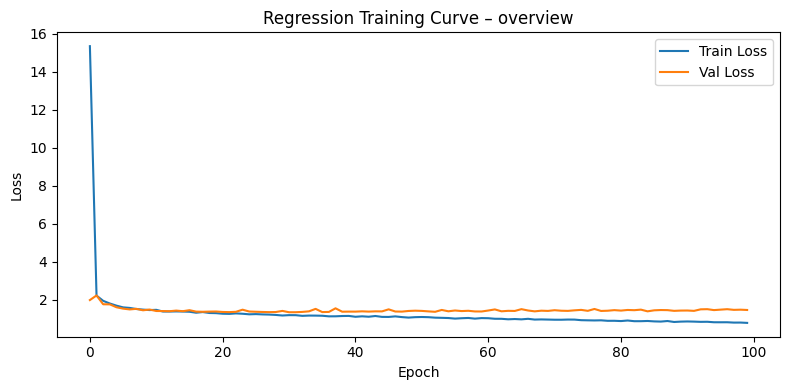

In [49]:
col = 'overview'
print(f"=== Task 3: Results on 'overview' ===")
print(f"=== Regression: input = '{col}' ===")

X_tr = embeddings[col]['train']
X_va = embeddings[col]['val']
X_te = embeddings[col]['test']

train_loader_reg = make_dataloader(X_tr, y_reg_train)
val_loader_reg   = make_dataloader(X_va, y_reg_val, shuffle=False)

reg_model_overview = RegressionNet(GLOVE_DIM).to(DEVICE)
loss_fn_reg = nn.MSELoss()

history_reg_overview = train_model(
    reg_model_overview, train_loader_reg, val_loader_reg,
    loss_fn_reg, epochs=100, lr=1e-3
)

# Evaluate on test set
reg_model_overview.eval()
with torch.no_grad():
    preds_overview = reg_model_overview(
        torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

mse_overview  = mean_squared_error(y_reg_test, preds_overview)
rmse_overview = np.sqrt(mse_overview)
print(f"\n── TEST RESULTS (overview) ──")
print(f"  MSE  : {mse_overview:.4f}")
print(f"  RMSE : {rmse_overview:.4f}")
print(f"  Baseline RMSE: {baseline_rmse:.4f}  ({'↓ improved' if rmse_overview < baseline_rmse else '↑ NOT better than baseline'})")

plot_loss_curve(history_reg_overview, f'Regression Training Curve – {col}')

---
## Task 3B: Regression with `keywords` Embeddings

Keywords are short but information-dense. We compare with overview.

=== Task 3: Results on 'keywords' ===
=== Regression: input = 'keywords' ===
  Epoch  10/50 | Train Loss: 1.3829 | Val Loss: 1.4767
  Epoch  20/50 | Train Loss: 1.2185 | Val Loss: 1.4244
  Epoch  30/50 | Train Loss: 1.1378 | Val Loss: 1.4286
  Epoch  40/50 | Train Loss: 1.0438 | Val Loss: 1.4366
  Epoch  50/50 | Train Loss: 0.9930 | Val Loss: 1.4011

── TEST RESULTS (keywords) ──
  MSE  : 1.3394
  RMSE : 1.1573
  Baseline RMSE: 1.1690


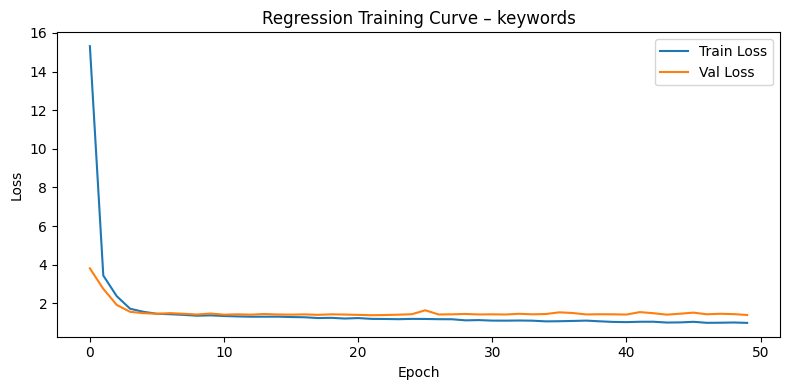

In [50]:
col = 'keywords'
print(f"=== Task 3: Results on 'keywords' ===")
print(f"=== Regression: input = '{col}' ===")

X_tr = embeddings[col]['train']
X_va = embeddings[col]['val']
X_te = embeddings[col]['test']

train_loader_reg_kw = make_dataloader(X_tr, y_reg_train)
val_loader_reg_kw   = make_dataloader(X_va, y_reg_val, shuffle=False)

reg_model_keywords = RegressionNet(GLOVE_DIM).to(DEVICE)

history_reg_keywords = train_model(
    reg_model_keywords, train_loader_reg_kw, val_loader_reg_kw,
    loss_fn_reg, epochs=50, lr=1e-3
)

reg_model_keywords.eval()
with torch.no_grad():
    preds_keywords = reg_model_keywords(
        torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

mse_keywords  = mean_squared_error(y_reg_test, preds_keywords)
rmse_keywords = np.sqrt(mse_keywords)
print(f"\n── TEST RESULTS (keywords) ──")
print(f"  MSE  : {mse_keywords:.4f}")
print(f"  RMSE : {rmse_keywords:.4f}")
print(f"  Baseline RMSE: {baseline_rmse:.4f}")

plot_loss_curve(history_reg_keywords, f'Regression Training Curve – {col}')

---
## Regression Results Comparison Table

=== Task 3 Results for Regression:  ===
        Model / Input    MSE   RMSE
      Baseline (mean) 1.3666 1.1690
Neural Net — overview 1.5046 1.2266
Neural Net — keywords 1.3394 1.1573


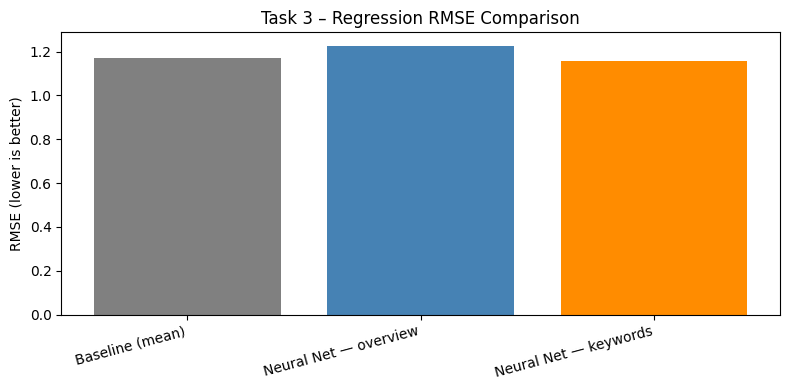

In [51]:
reg_results = pd.DataFrame({
    'Model / Input': ['Baseline (mean)', 'Neural Net — overview', 'Neural Net — keywords'],
    'MSE': [round(baseline_mse, 4), round(mse_overview, 4), round(mse_keywords, 4)],
    'RMSE': [round(baseline_rmse, 4), round(rmse_overview, 4), round(rmse_keywords, 4)]
})
print("=== Task 3 Results for Regression:  ===")
print(reg_results.to_string(index=False))

# Bar chart
plt.figure(figsize=(8, 4))
plt.bar(reg_results['Model / Input'], reg_results['RMSE'], color=['gray', 'steelblue', 'darkorange'])
plt.ylabel('RMSE (lower is better)')
plt.title('Task 3 – Regression RMSE Comparison')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

---
##  Prepare Multi-Label Classification Targets

**MultiLabelBinarizer** converts `['Action', 'Drama']` into a binary vector:
`[1, 0, 1, 0, 0, ...]` where 1 = this movie belongs to that genre.

We only keep genres that appear at least 50 times to avoid extremely rare labels.

In [36]:
MIN_GENRE_FREQ = 50
valid_genres = {g for g, c in genre_counts.items() if c >= MIN_GENRE_FREQ}
print(f"Genres with ≥{MIN_GENRE_FREQ} occurrences: {sorted(valid_genres)}")
print(f"Total: {len(valid_genres)} genres")

def filter_genres(genre_list):
    return [g for g in genre_list if g in valid_genres]

df['genre_filtered'] = df['genre_list'].apply(filter_genres)
train_df['genre_filtered'] = train_df['genre_list'].apply(filter_genres)
val_df['genre_filtered']   = val_df['genre_list'].apply(filter_genres)
test_df['genre_filtered']  = test_df['genre_list'].apply(filter_genres)

mlb = MultiLabelBinarizer(classes=sorted(valid_genres))
mlb.fit(train_df['genre_filtered'])

y_cls_train = mlb.transform(train_df['genre_filtered']).astype(np.float32)
y_cls_val   = mlb.transform(val_df['genre_filtered']).astype(np.float32)
y_cls_test  = mlb.transform(test_df['genre_filtered']).astype(np.float32)

NUM_LABELS = len(mlb.classes_)
print(f"\nLabel matrix shapes → train: {y_cls_train.shape}, val: {y_cls_val.shape}, test: {y_cls_test.shape}")
print(f"Genre labels: {list(mlb.classes_)}")

Genres with ≥50 occurrences: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'War', 'Western']
Total: 19 genres

Label matrix shapes → train: (3339, 19), val: (716, 19), test: (716, 19)
Genre labels: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'War', 'Western']


---
##  Task 4A: Multi-Label Genre Classification with `overview`

**BCEWithLogitsLoss** = Binary Cross Entropy with built-in sigmoid.  
It independently asks "does this movie belong to genre X?" for each genre.  

At inference, we apply sigmoid and threshold at 0.5 to get binary predictions.

=== Multi-Label Classification: input = 'overview' ===
  Epoch  10/80 | Train Loss: 0.2695 | Val Loss: 0.2665
  Epoch  20/80 | Train Loss: 0.2518 | Val Loss: 0.2572
  Epoch  30/80 | Train Loss: 0.2436 | Val Loss: 0.2543
  Epoch  40/80 | Train Loss: 0.2379 | Val Loss: 0.2538
  Epoch  50/80 | Train Loss: 0.2328 | Val Loss: 0.2546
  Epoch  60/80 | Train Loss: 0.2278 | Val Loss: 0.2548
  Epoch  70/80 | Train Loss: 0.2236 | Val Loss: 0.2549
  Epoch  80/80 | Train Loss: 0.2199 | Val Loss: 0.2542

── TEST RESULTS (overview) ──
  Micro-F1     : 0.5324
  Macro-F1     : 0.3876
  Hamming Loss : 0.1121  (lower is better; 0 = perfect)
  Jaccard Score: 0.4126  (higher is better; 1 = perfect)


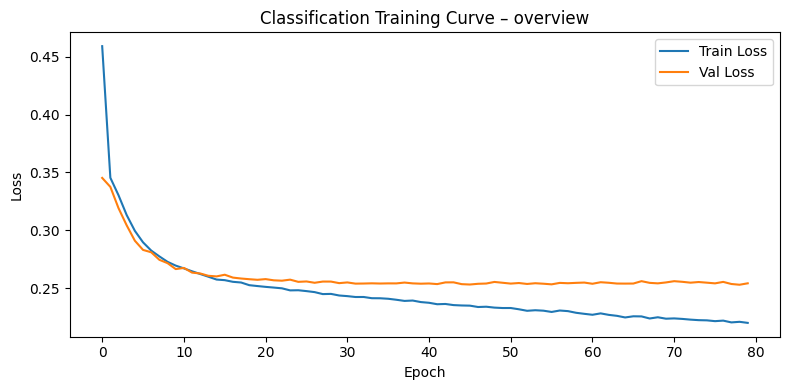

In [37]:
col = 'overview'
print(f"=== Multi-Label Classification: input = '{col}' ===")

X_tr = embeddings[col]['train']
X_va = embeddings[col]['val']
X_te = embeddings[col]['test']

train_loader_cls = make_dataloader(X_tr, y_cls_train)
val_loader_cls   = make_dataloader(X_va, y_cls_val, shuffle=False)

cls_model_overview = ClassificationNet(GLOVE_DIM, NUM_LABELS).to(DEVICE)
loss_fn_cls = nn.BCEWithLogitsLoss()

history_cls_overview = train_model(
    cls_model_overview, train_loader_cls, val_loader_cls,
    loss_fn_cls, epochs=80, lr=1e-3, task='classification'
)

# Predict on test set
cls_model_overview.eval()
with torch.no_grad():
    logits_overview = cls_model_overview(
        torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

# Convert logits → probabilities → binary labels
probs_overview = 1 / (1 + np.exp(-logits_overview))   # sigmoid
preds_cls_overview = (probs_overview >= 0.5).astype(int)

micro_f1_ov = f1_score(y_cls_test, preds_cls_overview, average='micro', zero_division=0)
macro_f1_ov = f1_score(y_cls_test, preds_cls_overview, average='macro', zero_division=0)
ham_ov      = hamming_loss(y_cls_test, preds_cls_overview)
jac_ov      = jaccard_score(y_cls_test, preds_cls_overview, average='samples', zero_division=0)

print(f"\n── TEST RESULTS (overview) ──")
print(f"  Micro-F1     : {micro_f1_ov:.4f}")
print(f"  Macro-F1     : {macro_f1_ov:.4f}")
print(f"  Hamming Loss : {ham_ov:.4f}  (lower is better; 0 = perfect)")
print(f"  Jaccard Score: {jac_ov:.4f}  (higher is better; 1 = perfect)")

plot_loss_curve(history_cls_overview, f'Classification Training Curve – {col}')

---
##  Task 4B: Multi-Label Classification with `keywords`

=== Multi-Label Classification: input = 'keywords' ===
  Epoch  10/80 | Train Loss: 0.2758 | Val Loss: 0.2779
  Epoch  20/80 | Train Loss: 0.2637 | Val Loss: 0.2758
  Epoch  30/80 | Train Loss: 0.2543 | Val Loss: 0.2754
  Epoch  40/80 | Train Loss: 0.2465 | Val Loss: 0.2758
  Epoch  50/80 | Train Loss: 0.2401 | Val Loss: 0.2782
  Epoch  60/80 | Train Loss: 0.2346 | Val Loss: 0.2784
  Epoch  70/80 | Train Loss: 0.2271 | Val Loss: 0.2816
  Epoch  80/80 | Train Loss: 0.2223 | Val Loss: 0.2838

── TEST RESULTS (keywords) ──
  Micro-F1     : 0.5014
  Macro-F1     : 0.3797
  Hamming Loss : 0.1155
  Jaccard Score: 0.3652


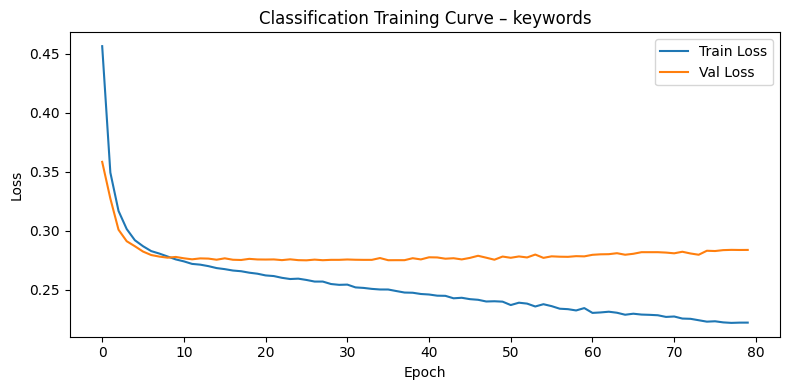

In [38]:
col = 'keywords'
print(f"=== Multi-Label Classification: input = '{col}' ===")

X_tr = embeddings[col]['train']
X_va = embeddings[col]['val']
X_te = embeddings[col]['test']

train_loader_cls_kw = make_dataloader(X_tr, y_cls_train)
val_loader_cls_kw   = make_dataloader(X_va, y_cls_val, shuffle=False)

cls_model_keywords = ClassificationNet(GLOVE_DIM, NUM_LABELS).to(DEVICE)

history_cls_keywords = train_model(
    cls_model_keywords, train_loader_cls_kw, val_loader_cls_kw,
    loss_fn_cls, epochs=80, lr=1e-3
)

cls_model_keywords.eval()
with torch.no_grad():
    logits_kw = cls_model_keywords(
        torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

probs_kw = 1 / (1 + np.exp(-logits_kw))
preds_cls_keywords = (probs_kw >= 0.5).astype(int)

micro_f1_kw = f1_score(y_cls_test, preds_cls_keywords, average='micro', zero_division=0)
macro_f1_kw = f1_score(y_cls_test, preds_cls_keywords, average='macro', zero_division=0)
ham_kw      = hamming_loss(y_cls_test, preds_cls_keywords)
jac_kw      = jaccard_score(y_cls_test, preds_cls_keywords, average='samples', zero_division=0)

print(f"\n── TEST RESULTS (keywords) ──")
print(f"  Micro-F1     : {micro_f1_kw:.4f}")
print(f"  Macro-F1     : {macro_f1_kw:.4f}")
print(f"  Hamming Loss : {ham_kw:.4f}")
print(f"  Jaccard Score: {jac_kw:.4f}")

plot_loss_curve(history_cls_keywords, f'Classification Training Curve – {col}')

---
## Classification Results Comparison Table

=== Task 4 Results: Multi-Label Classification  ===
Input Column  Micro-F1  Macro-F1  Hamming Loss  Jaccard
    overview    0.5324    0.3876        0.1121   0.4126
    keywords    0.5014    0.3797        0.1155   0.3652


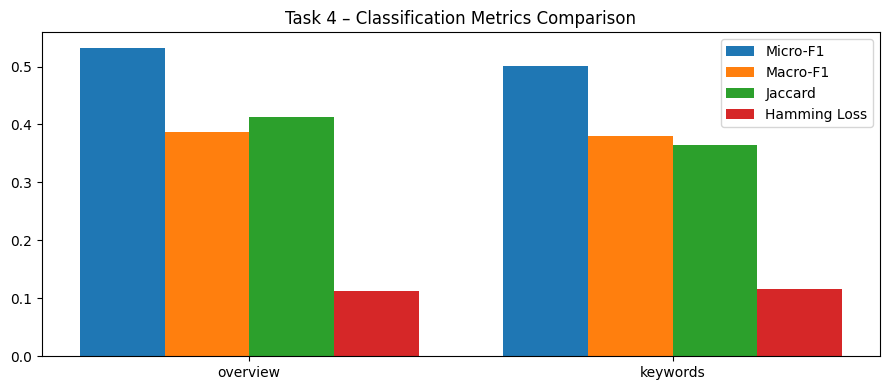

In [41]:
cls_results = pd.DataFrame({
    'Input Column': ['overview', 'keywords'],
    'Micro-F1':     [round(micro_f1_ov, 4), round(micro_f1_kw, 4)],
    'Macro-F1':     [round(macro_f1_ov, 4), round(macro_f1_kw, 4)],
    'Hamming Loss': [round(ham_ov, 4), round(ham_kw, 4)],
    'Jaccard':      [round(jac_ov, 4), round(jac_kw, 4)]
})
print("=== Task 4 Results: Multi-Label Classification  ===")
print(cls_results.to_string(index=False))

# Grouped bar chart
fig, ax = plt.subplots(figsize=(9, 4))
x = np.arange(2)
width = 0.2
ax.bar(x - 1.5*width, cls_results['Micro-F1'],  width, label='Micro-F1')
ax.bar(x - 0.5*width, cls_results['Macro-F1'],  width, label='Macro-F1')
ax.bar(x + 0.5*width, cls_results['Jaccard'],   width, label='Jaccard')
ax.bar(x + 1.5*width, cls_results['Hamming Loss'], width, label='Hamming Loss')
ax.set_xticks(x); ax.set_xticklabels(['overview', 'keywords'])
ax.set_title('Task 4 – Classification Metrics Comparison')
ax.legend(); plt.tight_layout(); plt.show()

---
## Task 5: Top 10 Most Frequent Words per Genre

We look at the `overview` of all movies in each genre and count word frequency.
We show top 10 AND bottom 10 (with minimum freq ≥ 3) as required.

In [42]:
# For each valid genre, collect all overview tokens from movies of that genre
def genre_word_freq(genre_name, full_df, text_col='overview_tokens', min_freq=3):
    """Return Counter of word frequencies for a given genre."""
    genre_mask = full_df['genre_list'].apply(lambda lst: genre_name in lst)
    tokens = [tok for tlist in full_df.loc[genre_mask, text_col] for tok in tlist]
    freq = Counter(tokens)
    freq_filtered = {w: c for w, c in freq.items() if c >= min_freq}
    return Counter(freq_filtered)


MIN_FREQ = 3
GENRES_TO_ANALYZE = sorted(valid_genres)   # same set used for classification

freq_results = {}
for genre in GENRES_TO_ANALYZE:
    freq_results[genre] = genre_word_freq(genre, df, min_freq=MIN_FREQ)

# Display top/bottom 10 for each genre in a clean table
print(f"{'Genre':<20} {'TOP 10 MOST FREQUENT':^60} {'BOTTOM 10 LEAST FREQ':^60}")
print("-" * 140)

for genre in GENRES_TO_ANALYZE:
    counter = freq_results[genre]
    if len(counter) == 0:
        continue
    top10 = ', '.join([f"{w}({c})" for w, c in counter.most_common(10)])
    bot10 = ', '.join([f"{w}({c})" for w, c in counter.most_common()[:-11:-1]])
    print(f"{genre:<20} {top10:<60} {bot10:<60}")

Genre                                    TOP 10 MOST FREQUENT                                         BOTTOM 10 LEAST FREQ                    
--------------------------------------------------------------------------------------------------------------------------------------------
Action               world(187), find(187), life(168), one(166), must(165), new(160), man(134), two(130), take(126), get(119) guitar(3), wiley(3), reagan(3), fred(3), evening(3), entei(3), stegman(3), hazen(3), gasoline(3), stagecoach(3)
Adventure            world(175), find(172), life(124), new(124), must(122), one(107), young(105), two(95), take(86), friend(82) wiley(3), ness(3), loch(3), herzog(3), goon(3), mcmaster(3), entei(3), taylor(3), hazen(3), deke(3)
Animation            world(69), find(59), new(52), life(50), friend(43), one(40), get(39), adventure(39), must(39), young(36) entei(3), parrotmon(3), digimon(3), kaneda(3), brendan(3), episode(3), recess(3), kai(3), anything(3), humphrey(3)
Comedy   

---
## Cell 21 – Task 5: Visualize Top 10 Words for Selected Genres

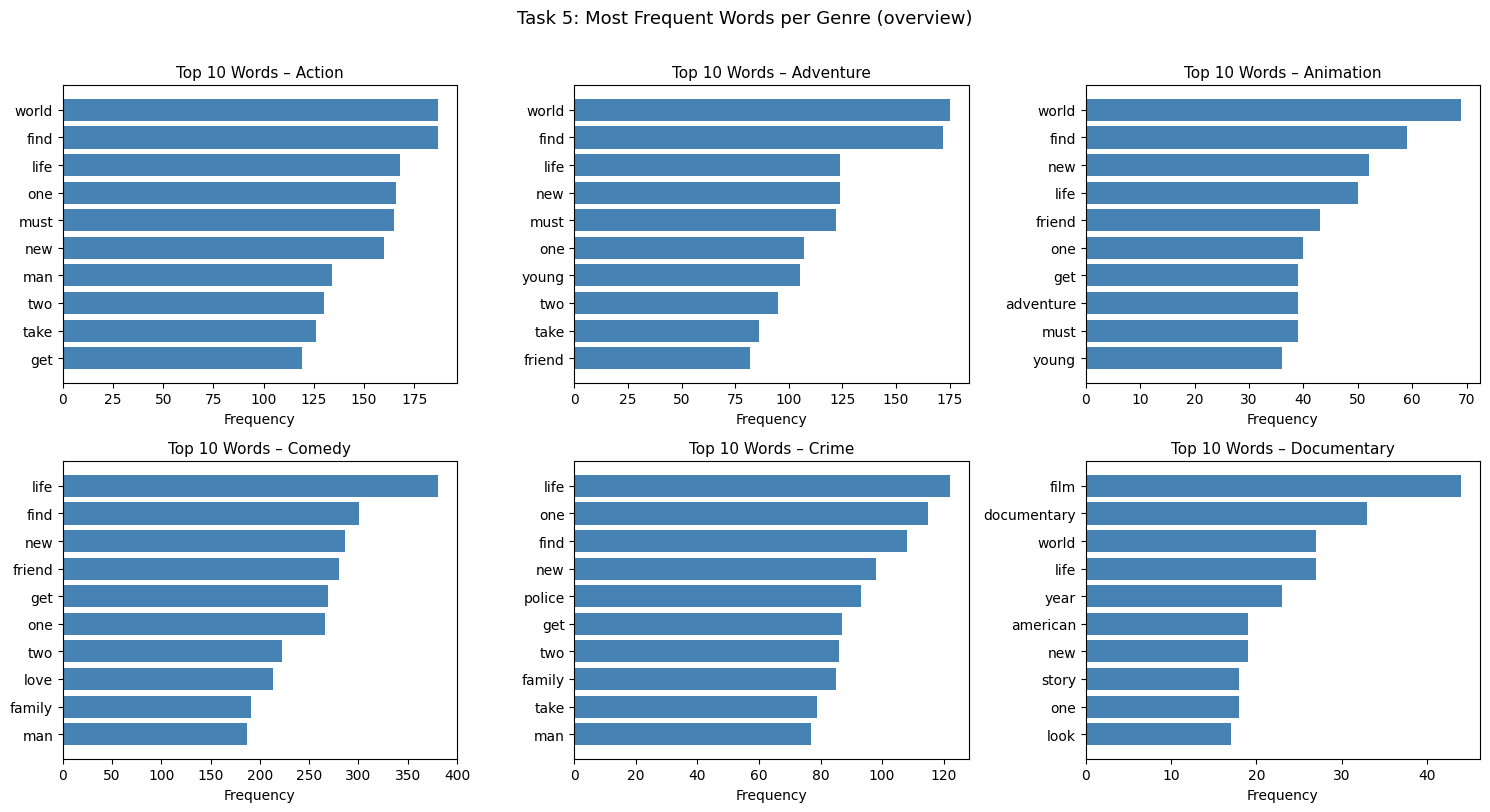

In [43]:
# Plot top-10 word frequency bar charts for a selection of genres
PLOT_GENRES = sorted(valid_genres)[:6]   # show first 6 alphabetically

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, genre in zip(axes, PLOT_GENRES):
    counter = freq_results[genre]
    if not counter:
        ax.set_visible(False)
        continue
    words, counts = zip(*counter.most_common(10))
    ax.barh(list(words)[::-1], list(counts)[::-1], color='steelblue')
    ax.set_title(f"Top 10 Words – {genre}", fontsize=11)
    ax.set_xlabel('Frequency')

plt.suptitle('Task 5: Most Frequent Words per Genre (overview)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## Cell 22 – Task 6: Genre-Indicative Words via TF-IDF + Logistic Regression

**Idea:** Train one logistic regression classifier per genre (binary: does this movie belong to genre X or not?).  
The model learns which words are positively associated with each genre.  
The highest-weight words = most indicative words for that genre.

We fit a new TF-IDF on the **full** corpus (all genres need coverage here) and use it
as input to logistic regression.

In [44]:
# Fit TF-IDF on training set overview texts (same column, fit only on train)
tfidf_for_logreg = TfidfVectorizer(max_features=5000, min_df=3)
tfidf_for_logreg.fit(train_df['overview_clean'])

X_full_tfidf = tfidf_for_logreg.transform(df['overview_clean'])
feature_names = np.array(tfidf_for_logreg.get_feature_names_out())

# Use full dataset for indicative word extraction (more data = better estimates)
X_train_tfidf = tfidf_for_logreg.transform(train_df['overview_clean'])

print("Training one logistic regression per genre...")
indicative_words = {}

for i, genre in enumerate(sorted(valid_genres)):
    # Binary label: 1 if movie is in this genre, 0 otherwise
    y_binary = (y_cls_train[:, i] == 1).astype(int)

    if y_binary.sum() < 10:   # skip genres with too few positive examples in train
        continue

    clf = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs')
    clf.fit(X_train_tfidf, y_binary)

    # Get top 10 positive-weight feature indices
    coefs = clf.coef_[0]
    top10_idx = coefs.argsort()[-10:][::-1]
    indicative_words[genre] = list(feature_names[top10_idx])

print("Done ✓")

Training one logistic regression per genre...
Done ✓


---
##  Task 6: Display Indicative Words Table

In [45]:
print("=" * 70)
print(f"{'GENRE':<20} {'TOP 10 INDICATIVE WORDS (TF-IDF + Logistic Regression)'}")
print("=" * 70)

for genre, words in sorted(indicative_words.items()):
    print(f"{genre:<20} {', '.join(words)}")

print("=" * 70)

# Also as a nicely formatted DataFrame
indic_df = pd.DataFrame([
    {'Genre': genre, 'Indicative Words': ', '.join(words)}
    for genre, words in sorted(indicative_words.items())
])
indic_df

GENRE                TOP 10 INDICATIVE WORDS (TF-IDF + Logistic Regression)
Action               agent, cop, criminal, hero, assassin, terrorist, ruthless, cia, battle, fight
Adventure            adventure, bond, save, king, power, world, jungle, dragon, dinosaur, set
Animation            adventure, animated, human, world, dragon, dinosaur, city, monster, penguin, animal
Comedy               comedy, show, wedding, romance, girlfriend, guy, think, single, couple, movie
Crime                police, cop, murder, drug, criminal, fbi, money, detective, mafia, crime
Documentary          documentary, film, look, filmmaker, interview, issue, fan, intimate, footage, music
Drama                story, life, struggle, change, wife, family, drama, mother, love, relationship
Family               adventure, dog, save, world, christmas, boy, land, friend, kid, little
Fantasy              evil, vampire, power, world, king, dragon, magic, century, ancient, battle
Fiction              alien, planet, eart

,Genre,Indicative Words
0,Action,"agent, cop, criminal, hero, assassin, terroris..."
1,Adventure,"adventure, bond, save, king, power, world, jun..."
2,Animation,"adventure, animated, human, world, dragon, din..."
3,Comedy,"comedy, show, wedding, romance, girlfriend, gu..."
4,Crime,"police, cop, murder, drug, criminal, fbi, mone..."
5,Documentary,"documentary, film, look, filmmaker, interview,..."
6,Drama,"story, life, struggle, change, wife, family, d..."
7,Family,"adventure, dog, save, world, christmas, boy, l..."
8,Fantasy,"evil, vampire, power, world, king, dragon, mag..."
9,Fiction,"alien, planet, earth, future, robot, human, sc..."


---
##  Task 6: Brief Interpretation (Fill This In)

Below is a template. After running, replace the placeholder text with the actual words from your output.

In [46]:
# Auto-generate interpretation text from results
print("=== Task 6 Interpretation Template ===")
print()
for genre, words in sorted(indicative_words.items()):
    top3 = ', '.join(words[:3])
    print(f"• {genre}: Words like '{top3}' suggest this genre because "
          f"[COMPLETE WITH YOUR OWN REASONING based on what these words imply].")
    print()

# Example output for Action:
# "Words like 'battle', 'fight', 'weapon' suggest Action because they directly
#  describe physical conflict and combat situations typical of action films."

=== Task 6 Interpretation Template ===

• Action: Words like 'agent, cop, criminal' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Adventure: Words like 'adventure, bond, save' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Animation: Words like 'adventure, animated, human' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Comedy: Words like 'comedy, show, wedding' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Crime: Words like 'police, cop, murder' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Documentary: Words like 'documentary, film, look' suggest this genre because [COMPLETE WITH YOUR OWN REASONING based on what these words imply].

• Drama: Words like 'story, life, struggle' suggest this genre because [COMPLETE WITH YOUR OWN REASO

---
## Result's Summary
This is the results summary required in your GitHub README.

In [47]:
print("══════════════════════════════════════════════════════")
print("           FINAL RESULTS SUMMARY – IT549 Lab 2")
print("══════════════════════════════════════════════════════")
print()
print("GloVe Embedding: 100D (wiki_giga_2024, ~1.29M words)")
print("Embedding Method: TF-IDF Weighted Average")
print("Split: 70% train / 15% val / 15% test")
print()

print("── TASK 3: Regression (predict voting_average) ──")
print(f"  Baseline (mean predictor) RMSE : {baseline_rmse:.4f}")
print(f"  Neural Net [overview]    RMSE  : {rmse_overview:.4f}")
print(f"  Neural Net [keywords]    RMSE  : {rmse_keywords:.4f}")
print()

print("── TASK 4: Multi-Label Classification (predict genres) ──")
print(f"  Neural Net [overview]  Micro-F1: {micro_f1_ov:.4f}  Macro-F1: {macro_f1_ov:.4f}  Hamming: {ham_ov:.4f}")
print(f"  Neural Net [keywords]  Micro-F1: {micro_f1_kw:.4f}  Macro-F1: {macro_f1_kw:.4f}  Hamming: {ham_kw:.4f}")
print()
print("── TASK 5: Top frequent words per genre: see Cell 20 ──")
print("── TASK 6: Genre-indicative words per genre: see Cell 23 ──")
print()
print("══════════════════════════════════════════════════════")

══════════════════════════════════════════════════════
           FINAL RESULTS SUMMARY – IT549 Lab 2
══════════════════════════════════════════════════════

GloVe Embedding: 100D (wiki_giga_2024, ~1.29M words)
Embedding Method: TF-IDF Weighted Average
Split: 70% train / 15% val / 15% test

── TASK 3: Regression (predict voting_average) ──
  Baseline (mean predictor) RMSE : 1.1690
  Neural Net [overview]    RMSE  : 1.2176
  Neural Net [keywords]    RMSE  : 1.1454

── TASK 4: Multi-Label Classification (predict genres) ──
  Neural Net [overview]  Micro-F1: 0.5324  Macro-F1: 0.3876  Hamming: 0.1121
  Neural Net [keywords]  Micro-F1: 0.5014  Macro-F1: 0.3797  Hamming: 0.1155

── TASK 5: Top frequent words per genre: see Cell 20 ──
── TASK 6: Genre-indicative words per genre: see Cell 23 ──

══════════════════════════════════════════════════════
